In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

import fancyimpute
from fancyimpute import IterativeImputer as MICE
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
#hide warnings
import warnings
warnings.filterwarnings('ignore')

In [77]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
import seaborn as sns

#### Data Understanding

In [3]:
#Reading the data set
df=pd.read_csv('telecom_churn_data.csv')

In [4]:
#Looking at data types of variables
df.info()
df.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


(99999, 226)

#### Treating nulls in the given data

In [6]:
# There are 20 columns for whcih the nan values can be replaced as zeroes based on data understanding
k=round((df.isnull().sum()/len(df.index))*100,2)
col_70=k[k>10].index
col_miss=col_70[4:24]

In [7]:
#Based on 2g and 3g recharges done by users replacing nan with 0 
for i in col_miss:
    df.loc[(df['monthly_2g_6']+df['monthly_3g_6']+df['sachet_2g_6']+df['sachet_3g_6']==0)&df[i]
           .isnull(),i]=0

In [9]:
# checking for columns which have nulls greater than 70% again after inputing and dropping them
r=round((df.isnull().sum()/len(df.index))*100,2)
r[r>10]
df_70=df[[i for i in df.columns if i not in r[r>10] and  i not in 'mobile_number']]

In [0]:
train_cols=df_70.columns

In [10]:
#Checking the columns which are categorical and have minimum variance with target and removing the columns
col_imp=df[r[(r<10) & (r>0)].index].dtypes
col_imp=col_imp[col_imp=='object']
col_imp.index
df_10=df_70[[i for i in df_70.columns if i not in col_imp.index and i!='last_date_of_month_6']]

In [13]:
train_cols=df_10.columns
len(train_cols)

197

#### Using Iterative imputer imputing continous varaibles on standardized data 

In [198]:
#Excecution time for iterative imputer is about 65 mins
df_10=pd.DataFrame(MICE(random_state=0,verbose=0).fit_transform(StandardScaler().fit_transform(df_10)))
df_10.columns=train_cols
df_final=pd.concat([df_70[[i for i in df_70.columns if i not in train_cols]],df_10[train_cols]],axis=1,sort=False)

NameError: name 'MICE' is not defined

#### Filtering for high value customers

In [5]:
#Calculating reveue generated by each customer for filtering high value customers
df_final['high_rev']=(df_final['total_rech_amt_6']+df_final['av_rech_amt_data_6']+df_final['total_rech_amt_7']+df_final['av_rech_amt_data_7'])/2

In [6]:
#calculating value at 70 percentile and applying filter
ctf=df_final.high_rev.quantile(0.7)
dff=df_final[df_final['high_rev']>=ctf]
len(dff.index)

30000

#### Creating target variable using month-9 data

In [7]:
# Calculate total usage based on four columns
col_tgt=['total_ic_mou_9','total_og_mou_9','vol_3g_mb_9','vol_2g_mb_9']
dff['total_usage']=dff[col_tgt].sum(axis=1)

In [8]:
#Churn target valibale creation
min_val=dff[col_tgt].sum(axis=1).min()
dff['Churn']=(dff['total_usage']==min_val).astype(int)
dff['Churn'].value_counts()

0    27596
1     2404
Name: Churn, dtype: int64

In [9]:
#Dropping 9 month colummns
col_9_d=dff.columns[dff.columns.str.contains('9')]
dff.drop(col_9_d,axis=1,inplace=True)


In [10]:
col_uni=dff.columns[(dff.columns.str.contains('mou'))|(dff.columns.str.contains('arpu'))|(dff.columns.str.contains('amt'))]

#### Data Analysis

Text(0.5, 0, 'total_og_mou_6')

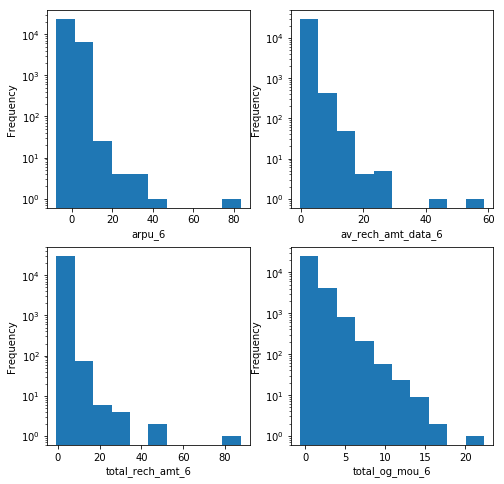

In [20]:
# Univariate analysis for features:'arpu_6','av_rech_amt_data_6','total_rech_amt_6','total_og_mou_6'
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
dff['arpu_6'].plot(kind='hist')
plt.yscale('log')
plt.xlabel('arpu_6')
plt.subplot(2,2,2)
dff['av_rech_amt_data_6'].plot(kind='hist')
plt.yscale('log')
plt.xlabel('av_rech_amt_data_6')
plt.subplot(2,2,3)
dff['total_rech_amt_6'].plot(kind='hist')
plt.yscale('log')
plt.xlabel('total_rech_amt_6')
plt.subplot(2,2,4)
dff['total_og_mou_6'].plot(kind='hist')
plt.yscale('log')
plt.xlabel('total_og_mou_6')

In [21]:
#Since numerical variables are lacking gaussian distribution, we apply Power Transformations
#to make the distribution uniform
pt=PowerTransformer(standardize=False)
dff[col_uni]=pt.fit_transform(dff[col_uni])

Text(0.5, 0, 'total_og_mou_6')

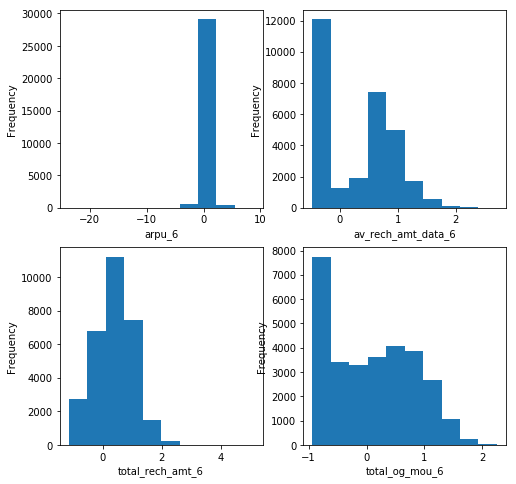

In [23]:
#Now we can see that the distribuition of these feauture is close to gaussian distribution
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
dff['arpu_6'].plot(kind='hist')
#plt.yscale('log')
plt.xlabel('arpu_6')
plt.subplot(2,2,2)
dff['av_rech_amt_data_6'].plot(kind='hist')
#plt.yscale('log')
plt.xlabel('av_rech_amt_data_6')
plt.subplot(2,2,3)
dff['total_rech_amt_6'].plot(kind='hist')
#plt.yscale('log')
plt.xlabel('total_rech_amt_6')
plt.subplot(2,2,4)
dff['total_og_mou_6'].plot(kind='hist')
#plt.yscale('log')
plt.xlabel('total_og_mou_6')

In [24]:
#We are considering outliers in the data set as there is a high class imbalance and by removing outliers 
#it may further increase the imbalance ratio
dff[col_uni].describe()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,...,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8
count,30000.0,30000.0,30000.0,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,0.0,0.0,0.0,0.467929,0.449325,0.275019,-0.122388,-0.121343,-0.160326,0.015128,...,0.240113,0.220484,0.216811,0.141541,0.031975,0.031043,-0.085099,0.251822,0.260516,0.143611
std,0.0,0.0,0.0,0.746778,0.717691,0.725611,0.485379,0.474683,0.454227,0.643343,...,0.724468,0.597142,0.610814,0.707979,0.663203,0.672231,0.658199,0.643366,0.636439,0.625521
min,0.0,0.0,0.0,-23.672478,-20.649119,-8.926220,-0.687120,-0.665967,-0.677149,-0.926493,...,-1.056283,-1.301564,-1.240505,-1.185017,-0.916460,-0.868552,-0.862529,-0.469097,-3.374111,-5.951661
25%,0.0,0.0,0.0,-0.045913,-0.037438,-0.214275,-0.584053,-0.573437,-0.594539,-0.565611,...,-0.264326,0.043387,0.041191,-0.389966,-0.488167,-0.518826,-0.862529,-0.469097,-0.501731,-0.533131
50%,0.0,0.0,0.0,0.468254,0.457349,0.318864,-0.224016,-0.226994,-0.262603,0.017682,...,0.284059,0.175185,0.182893,0.253146,0.244692,-0.103861,-0.131220,0.446308,0.454481,0.137761
75%,0.0,0.0,0.0,0.913821,0.881527,0.761866,0.286484,0.277658,0.196674,0.525808,...,0.738667,0.562653,0.552006,0.545298,0.437340,0.516120,0.454850,0.771450,0.780771,0.641319
max,0.0,0.0,0.0,8.766994,8.392317,5.714518,0.888453,0.860904,0.791993,1.762614,...,5.525080,2.862471,2.929106,3.933912,2.541763,2.451904,2.037502,2.705415,2.558191,2.107224


#### Data Cleaning and preparation

In [25]:
#Dropping the unwanted collumns
dff.drop('Unnamed: 0',axis=1,inplace=True)
#Dropping the variables related to 9th month before modelling
dff.drop('high_rev',axis=1,inplace=True)
dff.drop('total_usage',axis=1,inplace=True)

In [26]:
#Separating target variable and performimg train test split
var_cols=dff.columns[dff.columns!='Churn']
df_train,df_test = train_test_split( dff, test_size=0.33, random_state=0)

In [27]:
#creating Prinicple Components
pca=PCA(random_state=0)
pca.fit(df_train[var_cols])

PCA(copy=True, iterated_power='auto', n_components=None, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)

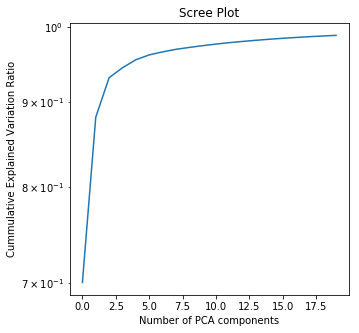

In [29]:
#plotting Scree graph
var_ratio=pca.explained_variance_ratio_[0:20]
var_cum=np.cumsum(var_ratio)
plt.figure(figsize=(5,5))
plt.title('Scree Plot')
plt.xlabel('Number of PCA components')
plt.ylabel('Cummulative Explained Variation Ratio')
plt.yscale('log')
plt.plot(var_cum)
plt.show()

In [30]:
#by looking at the graph we can see 98% of the variance in the data
#is explained by 15 PCAs

#transforming data to PCAs
pca2=PCA(n_components=15,random_state=0)
pc_data=pca2.fit_transform(df_train[var_cols])

In [31]:
#creating Df for PCAs
df_pc=pd.DataFrame(pc_data,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12',
                                    'PC13','PC14','PC15'])
df_pc.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
0,-7.358361,0.711630,-0.034873,6.358601,-5.157109,-6.378951,-1.189432,-0.114757,-5.379622,-4.729070,-3.359352,0.774519,0.410011,3.063350,4.054472
1,-7.450730,0.511059,-0.235167,4.096034,11.770319,-7.789121,-0.807383,-1.897541,1.295460,1.543242,-2.969962,0.317673,-2.147852,-1.377007,-5.006303
2,-7.484300,0.527472,-0.222282,-2.290198,1.494853,0.524566,-0.667988,-0.651347,-1.287711,2.388209,2.065049,-0.374258,-1.097105,0.866754,1.652435
3,101.217346,-85.200508,-7.792799,-3.183738,-0.720975,2.381513,-1.485275,1.982553,-0.577705,0.462189,0.194830,-0.529956,-0.376198,0.038639,-0.275943
4,-7.645278,0.478027,-0.828525,0.999491,0.829570,4.186361,-1.970948,2.797099,-0.191627,1.822254,0.971004,-0.944985,1.010820,-1.178450,0.847535


In [32]:
df_pc['Churn']=list(df_train['Churn'])
pc_col=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12',
                                    'PC13','PC14','PC15']

In [33]:
df_pc['Churn'].value_counts()

0    18497
1     1603
Name: Churn, dtype: int64

#### Data Modeling

In [34]:
#Training the model with LR
#using sklearn model for building the logistic regression model
lr=LogisticRegression(class_weight='balanced')
lr.fit(df_pc[pc_col],df_pc['Churn'])

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [35]:
df_train['prob']=list(lr.predict_proba(df_pc[pc_col])[:,1])

In [36]:
#Function for ROC curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

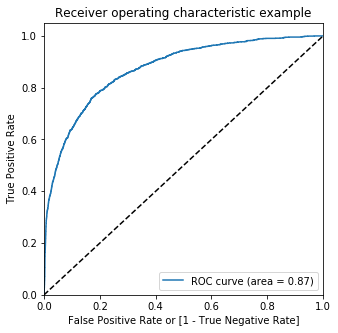

In [37]:
# Roc curve which is desirable and occupying maximum area possible
draw_roc(df_train['Churn'], df_train['prob'])

In [38]:
#predicting the target values by using different cut offs
numbers=[float(x)/10 for x in range(10)]
for i in numbers:
    df_train[i]=df_train.prob.map(lambda x: 1 if x> i else 0)
df_train.head()

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,...,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
49099,0.0,0.0,0.0,0.0,-0.092448,0.115523,-0.189854,-0.651970,-0.566411,-0.661957,...,1,1,1,0,0,0,0,0,0,0
43916,0.0,0.0,0.0,0.0,-0.376268,-0.064777,-1.027289,-0.687120,-0.665967,-0.677149,...,1,1,1,1,1,0,0,0,0,0
87157,0.0,0.0,0.0,0.0,0.286789,-0.326941,0.316463,-0.445329,-0.447693,-0.471585,...,1,1,0,0,0,0,0,0,0,0
19640,0.0,0.0,0.0,0.0,2.233138,0.859130,-1.101875,0.112914,-0.482091,0.042097,...,1,1,1,1,1,1,1,1,1,1
21306,0.0,0.0,0.0,0.0,1.630246,1.460190,1.909555,0.490775,0.057618,0.478606,...,1,0,0,0,0,0,0,0,0,0


In [39]:
#For different cut offs calculating the metrics
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(df_train['Churn'], df_train[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.079751  1.000000  0.000000
0.1   0.1  0.322388  0.981909  0.265232
0.2   0.2  0.486766  0.952589  0.446397
0.3   0.3  0.617164  0.909545  0.591826
0.4   0.4  0.712438  0.857143  0.699897
0.5   0.5  0.790249  0.791641  0.790128
0.6   0.6  0.855622  0.696195  0.869438
0.7   0.7  0.904030  0.563943  0.933503
0.8   0.8  0.927662  0.421085  0.971563
0.9   0.9  0.934428  0.336245  0.986268


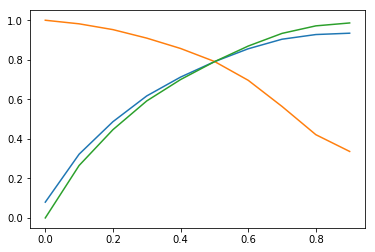

In [40]:
#Plotting the metrics accuracy,sensitivity,specificity as the intersection is at 0.5 we take cutoff as 0.5
plt.plot(cutoff_df['accuracy'])
plt.plot(cutoff_df['sensi'])
plt.plot(cutoff_df['speci'])
plt.show()

In [48]:
df_train['prob_pred']=df_train.prob.map(lambda x: 1 if x> 0.48 else 0)

In [50]:
#Accuracy for the train set
metrics.accuracy_score(df_train['Churn'],df_train['prob_pred'])

0.7759701492537313

In [51]:
#statistically 0.5 is idela cut-off since we are dealing with churn rate we chose 0.48 as cutoff which is giving 
#high sensitivity
cm1 = metrics.confusion_matrix(df_train['Churn'], df_train['prob_pred'] )
total1=sum(sum(cm1))
accuracy = (cm1[0,0]+cm1[1,1])/total1
speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print(accuracy,speci,sensi)

0.7759701492537313 0.7733686543763854 0.8059887710542732


In [52]:
df_pc_test=pca2.transform(df_test[var_cols])

In [53]:
df_pc_test=pd.DataFrame(df_pc_test,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12',
                                    'PC13','PC14','PC15'])
df_pc_test.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
0,-7.439858,0.520743,-0.271317,-4.153850,-0.490711,1.888264,0.553709,-1.003833,0.880077,-1.693610,-0.103667,0.116093,0.055833,0.359306,0.244946
1,-7.559070,0.443915,-0.618529,1.047235,6.792277,-0.365760,-2.044602,-3.061691,-1.039168,-0.564276,0.757203,-0.011353,-1.299552,-0.932722,0.366342
2,-7.530614,0.482023,-0.633307,-0.800626,0.805188,0.812020,-0.861362,-1.103940,0.463050,1.730165,-0.672917,-0.226083,0.502772,-0.513271,1.354754
3,-7.435278,0.531301,-0.250472,-3.954746,-1.153716,1.249974,0.383195,-0.363336,-0.763269,1.609516,0.686501,-0.509296,-0.665380,1.004629,0.207763
4,-7.632100,0.270804,-0.166316,-3.997030,-0.583944,1.654917,0.437546,-0.660510,0.158895,-0.306416,0.297560,2.085072,0.177860,0.446368,0.116215


In [54]:
df_pc_test['Churn']=list(df_test['Churn'])

In [55]:
#Predicting the prob for test data
df_test['prob']=list(lr.predict_proba(df_pc_test[pc_col])[:,1])

In [57]:
#assigning the conversion predicted with the cutoff 0.5
df_test['prob_pred']=df_test.prob.map(lambda x: 1 if x> 0.48 else 0)

In [58]:
#Accuracy of the test data
metrics.accuracy_score(df_test['Churn'],df_test['prob_pred'])

0.7688888888888888

In [60]:
#test data accuarcy nad sensitvity 
cm1 = metrics.confusion_matrix(df_test['Churn'], df_test['prob_pred'] )
total1=sum(sum(cm1))
accuracy = (cm1[0,0]+cm1[1,1])/total1
speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print(accuracy,speci,sensi)

0.7688888888888888 0.766677656885372 0.7940074906367042


In [61]:
#Clustering
#creating Prinicple Components
pca_clus=PCA(random_state=0)
pca_clus.fit(dff[var_cols])

PCA(copy=True, iterated_power='auto', n_components=None, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)

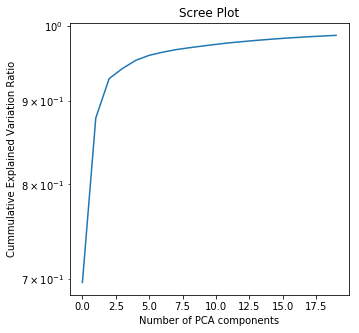

In [63]:
#plotting Scree graph
var_ratio=pca_clus.explained_variance_ratio_[0:20]
var_cum=np.cumsum(var_ratio)
plt.figure(figsize=(5,5))
plt.title('Scree Plot')
plt.xlabel('Number of PCA components')
plt.ylabel('Cummulative Explained Variation Ratio')
plt.yscale('log')
plt.plot(var_cum)
plt.show()

In [64]:
#transforming data to PCAs
pca2_clus=PCA(n_components=15,random_state=0)
pc_data_clus=pca2_clus.fit_transform(dff[var_cols])

In [65]:
#creating Df for PCAs
df_pc_clus=pd.DataFrame(pc_data_clus,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12',
                                    'PC13','PC14','PC15'])
df_pc_clus.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
0,-95.461200,133.647912,26.198861,-2.435483,0.305259,0.317798,0.703569,-2.060604,1.245278,1.367365,-0.531208,-0.239132,0.495646,0.372991,-0.394647
1,7.590385,0.443704,-0.571851,-3.993648,-1.413964,2.349378,-1.042454,1.662044,-0.750310,2.395717,0.657327,0.986426,0.572193,0.118851,0.474742
2,7.283470,0.536253,-0.200509,-0.816921,1.173052,-0.715726,-0.243347,-0.340883,-0.038965,-3.261497,0.791630,0.642404,0.421529,-1.433215,1.453777
3,7.233929,0.638984,-0.100194,0.369487,-1.383280,-6.159605,2.804549,0.838625,-0.435372,-0.826146,0.952066,-0.086244,-0.162540,-0.002475,-0.619929
4,7.318540,0.485597,-0.337290,-4.229684,0.565458,3.120700,-0.733651,0.359863,0.907979,-2.628041,-0.722799,0.685346,-0.631771,0.092407,-0.282913


In [66]:
df_pc_clus['Churn']=list(dff['Churn'])

In [70]:
#looking at hopkins stat to see if the data is good for clustering
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [71]:
hopkins(df_pc_clus)
#hopiks score looks good, so we are good to cluster the data

0.9864660541797543

In [72]:
# we will be clustering the data into 3 clusters as we know we have two classes
y=df_pc_clus.Churn.map(lambda x: 1 if x==0 else 11.82)
kmean=KMeans(n_clusters=2,max_iter=50,random_state=0)
kmean.fit(df_pc_clus[pc_col],sample_weight=y)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [73]:
df_pc_clus['Cluster_ID']=kmean.labels_

In [74]:
#Accuracy of the data
metrics.accuracy_score(df_pc_clus['Churn'],df_pc_clus['Cluster_ID'])

0.9318333333333333

In [75]:
dff['Cluster_ID']=kmean.labels_

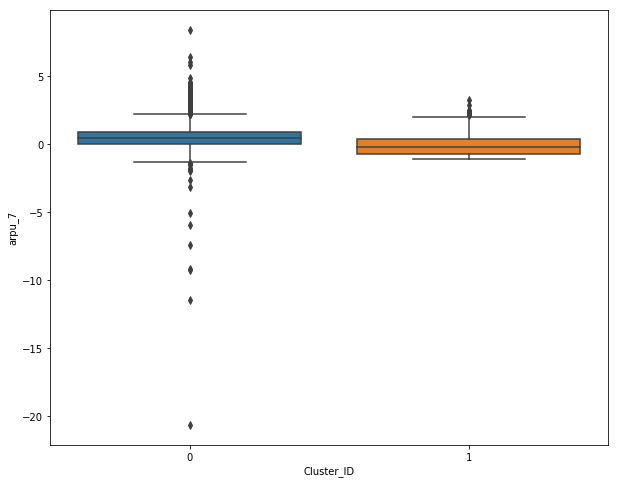

In [78]:
#looking at the distribution of each PCA across clusters
plt.figure(figsize=(10,8))
#y=PC1,PC2,PC3
sns.boxplot(x='Cluster_ID',y='arpu_7',data=dff)
plt.show()

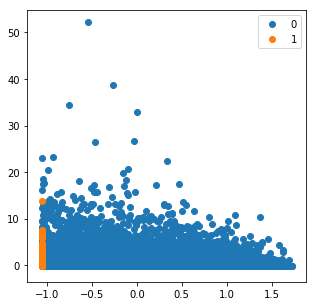

In [80]:
#Scatter plot between total_ic_mou_8 and vol_2g_mb_8 across the clusters
plt.figure(figsize=(5,5))
plt.scatter(dff[dff['Cluster_ID']==0]['total_ic_mou_8'],dff[dff['Cluster_ID']==0]['vol_2g_mb_8'])
plt.scatter(dff[dff['Cluster_ID']==1]['total_ic_mou_8'],dff[dff['Cluster_ID']==1]['vol_2g_mb_8'])
plt.legend(['0','1'])
plt.show()

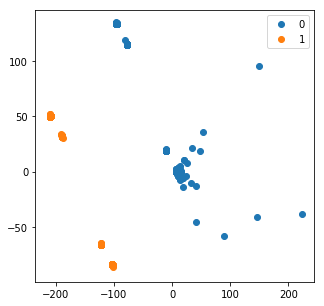

In [81]:
plt.figure(figsize=(5,5))
plt.scatter(df_pc_clus[df_pc_clus['Cluster_ID']==0]['PC1'],df_pc_clus[df_pc_clus['Cluster_ID']==0]['PC2'])
plt.scatter(df_pc_clus[df_pc_clus['Cluster_ID']==1]['PC1'],df_pc_clus[df_pc_clus['Cluster_ID']==1]['PC2'])
plt.legend(['0','1'])
plt.show()

In [82]:
cm1 = metrics.confusion_matrix(df_pc_clus['Churn'], df_pc_clus['Cluster_ID'] )
total1=sum(sum(cm1))
accuracy = (cm1[0,0]+cm1[1,1])/total1
speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print(accuracy,speci,sensi)

0.9318333333333333 0.9825337005363096 0.3498336106489185


Here we see that during cluster analysis we are not able to differentiate between the two cluster. There is no much difference in the box plot of any two variables.Here we can see a huge dip in sensitivity

So we now move to build XGboost Random Forest Tree model.

In [83]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=3, n_estimators=10,label=[0,1],weight=[1,11.82])

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      


In [84]:
model_cv.fit(df_pc[pc_col],df_pc['Churn'])

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    6.3s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, label=[0, 1],
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1, weight=[1, 11.82]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.2, 0.6], 'subsample': [0.3, 0.6, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [85]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.362885,0.168407,0.013211,0.001896,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.844590,0.861296,0.846884,0.850923,0.007394,6,0.864641,0.859165,0.863171,0.862325,0.002314
1,0.316192,0.006797,0.009206,0.006676,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.844198,0.864337,0.844413,0.850983,0.009443,5,0.866166,0.862786,0.864005,0.864319,0.001398
2,0.342646,0.010495,0.012872,0.001993,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.842444,0.862227,0.851405,0.852025,0.008088,4,0.865549,0.862396,0.867568,0.865171,0.002128
3,0.244784,0.007364,0.010419,0.007367,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.855229,0.867002,0.857649,0.859960,0.005076,3,0.884474,0.875633,0.881512,0.880540,0.003674
4,0.317698,0.007367,0.010420,0.007368,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.859386,0.879596,0.863975,0.867652,0.008651,2,0.893810,0.894935,0.894324,0.894356,0.000460
5,0.354156,0.007365,0.010420,0.007368,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.866918,0.874416,0.867443,0.869592,0.003418,1,0.901279,0.896486,0.898803,0.898856,0.001957


In [86]:
cv_results['param_learning_rate'] = cv_results['param_learning_rate'].astype('float')
#cv_results['param_max_depth'] = cv_results['param_max_depth'].astype('float')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.362885,0.168407,0.013211,0.001896,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.844590,0.861296,0.846884,0.850923,0.007394,6,0.864641,0.859165,0.863171,0.862325,0.002314
1,0.316192,0.006797,0.009206,0.006676,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.844198,0.864337,0.844413,0.850983,0.009443,5,0.866166,0.862786,0.864005,0.864319,0.001398
2,0.342646,0.010495,0.012872,0.001993,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.842444,0.862227,0.851405,0.852025,0.008088,4,0.865549,0.862396,0.867568,0.865171,0.002128
3,0.244784,0.007364,0.010419,0.007367,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.855229,0.867002,0.857649,0.859960,0.005076,3,0.884474,0.875633,0.881512,0.880540,0.003674
4,0.317698,0.007367,0.010420,0.007368,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.859386,0.879596,0.863975,0.867652,0.008651,2,0.893810,0.894935,0.894324,0.894356,0.000460


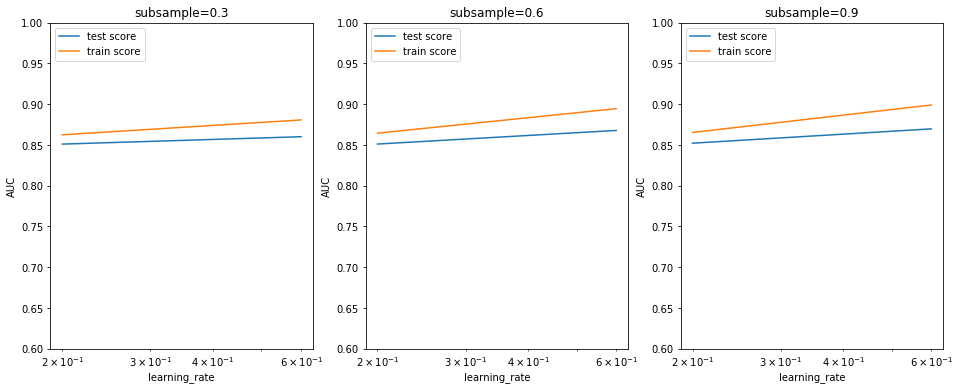

In [87]:
# # plotting
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.2, 0.6,0.8], 
             'subsample': [0.3, 0.6, 0.9]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

In [88]:
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for auc
prams = {'learning_rate': 0.2,
          'max_depth': 2, 
          'n_estimators':10,
          'subsample':0.9,
         'objective':'binary:logistic'}

# fit model on training data
model1 = XGBClassifier(learning_rate= 0.2,max_depth=4, n_estimators=10,label=[0,1],weight=[1,11.82],subsample=0.6,
                       objective='binary:logistic')
model1.fit(df_pc[pc_col],df_pc['Churn'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, label=[0, 1],
       learning_rate=0.2, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9, verbosity=1, weight=[1, 11.82])

In [89]:
y_pred = model1.predict_proba(df_pc[pc_col])


In [90]:
roc = metrics.roc_auc_score(df_pc['Churn'], y_pred[:, 1])
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 87.48%


In [107]:
y_pred_test = model1.predict_proba(df_pc_test[pc_col])

In [92]:
df_train['xg_prob']=list(y_pred[:, 1])

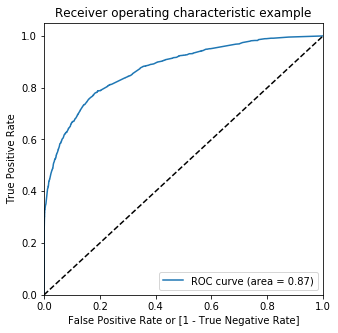

In [93]:
# Roc curve which is desirable and occupying maximum area possible
draw_roc(df_train['Churn'], df_train['xg_prob'])

In [94]:
#predicting the target values by using different cut offs
numbers=[float(x)/10 for x in range(10)]
for i in numbers:
    df_train[i]=df_train.xg_prob.map(lambda x: 1 if x> i else 0)
df_train.head()

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,...,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,prob_pred,xg_prob
49099,0.0,0.0,0.0,0.0,-0.092448,0.115523,-0.189854,-0.651970,-0.566411,-0.661957,...,0,0,0,0,0,0,0,0,0,0.122096
43916,0.0,0.0,0.0,0.0,-0.376268,-0.064777,-1.027289,-0.687120,-0.665967,-0.677149,...,0,0,0,0,0,0,0,0,0,0.172577
87157,0.0,0.0,0.0,0.0,0.286789,-0.326941,0.316463,-0.445329,-0.447693,-0.471585,...,0,0,0,0,0,0,0,0,0,0.078834
19640,0.0,0.0,0.0,0.0,2.233138,0.859130,-1.101875,0.112914,-0.482091,0.042097,...,1,1,1,1,1,1,1,0,1,0.845797
21306,0.0,0.0,0.0,0.0,1.630246,1.460190,1.909555,0.490775,0.057618,0.478606,...,0,0,0,0,0,0,0,0,0,0.072206


In [95]:
#For different cut offs calculating the metrics
cutoff_df = pd.DataFrame( columns = ['xg_prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(df_train['Churn'], df_train[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     xg_prob  accuracy     sensi     speci
0.0      0.0  0.079751  1.000000  0.000000
0.1      0.1  0.619353  0.898316  0.595178
0.2      0.2  0.909652  0.596382  0.936801
0.3      0.3  0.939303  0.438553  0.982700
0.4      0.4  0.943632  0.343107  0.995675
0.5      0.5  0.944229  0.331254  0.997351
0.6      0.6  0.942935  0.302558  0.998432
0.7      0.7  0.941144  0.269495  0.999351
0.8      0.8  0.938209  0.228322  0.999730
0.9      0.9  0.920249  0.000000  1.000000


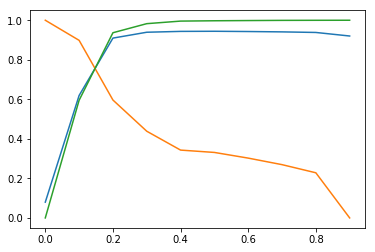

In [96]:
#Plotting the metrics accuracy,sensitivity,specificity as the intersection is at 0.16 we take cutoff as 0.16
plt.plot(cutoff_df['accuracy'])
plt.plot(cutoff_df['sensi'])
plt.plot(cutoff_df['speci'])
plt.show()

In [101]:
#statistically 0.16 is idela cut-off since we are dealing with churn rate we chose 0.12 as cutoff which is giving 
#high sensitivity
df_train['xg_prob_pred']=df_train.xg_prob.map(lambda x: 1 if x> 0.12 else 0)
metrics.accuracy_score(df_train['Churn'],df_train['xg_prob_pred'])
cm1 = metrics.confusion_matrix(df_train['Churn'], df_train['xg_prob_pred'] )
accuracy = (cm1[0,0]+cm1[1,1])/total1
speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])

In [102]:
print(accuracy,speci,sensi)

0.7756218905472637 0.7730983402713953 0.8047411104179664


In [111]:
roc = metrics.roc_auc_score(df_pc_test['Churn'], y_pred_test[:, 1])
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 85.11%


#### By comparing three models we choosed linear regression model which has better sensitivty over other models 

In [118]:
#LR with RFE to list the top 20 features
lr_rfe=LogisticRegression(class_weight='balanced')
lr_rfe.fit(df_train[var_cols],df_train['Churn'])

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [119]:
#Selecting Top 20 variable using RFE
rfe_tt=RFE(lr_rfe,20)
rfe_tt=rfe_tt.fit(df_train[var_cols],df_train['Churn'])

In [120]:
#Significance of each feature in the model
list(zip(df_train[var_cols].columns,rfe_tt.support_,rfe_tt.ranking_))

[('circle_id', False, 131),
 ('loc_og_t2o_mou', False, 130),
 ('std_og_t2o_mou', False, 129),
 ('loc_ic_t2o_mou', False, 128),
 ('arpu_6', False, 86),
 ('arpu_7', False, 20),
 ('arpu_8', False, 39),
 ('onnet_mou_6', False, 25),
 ('onnet_mou_7', True, 1),
 ('onnet_mou_8', True, 1),
 ('offnet_mou_6', False, 95),
 ('offnet_mou_7', False, 2),
 ('offnet_mou_8', False, 4),
 ('roam_ic_mou_6', False, 23),
 ('roam_ic_mou_7', False, 18),
 ('roam_ic_mou_8', False, 92),
 ('roam_og_mou_6', False, 49),
 ('roam_og_mou_7', False, 83),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2t_mou_6', False, 72),
 ('loc_og_t2t_mou_7', False, 91),
 ('loc_og_t2t_mou_8', False, 11),
 ('loc_og_t2m_mou_6', False, 81),
 ('loc_og_t2m_mou_7', False, 105),
 ('loc_og_t2m_mou_8', False, 33),
 ('loc_og_t2f_mou_6', False, 64),
 ('loc_og_t2f_mou_7', False, 43),
 ('loc_og_t2f_mou_8', False, 103),
 ('loc_og_t2c_mou_6', False, 111),
 ('loc_og_t2c_mou_7', False, 47),
 ('loc_og_t2c_mou_8', False, 46),
 ('loc_og_mou_6', False, 60),
 ('lo

In [121]:
tar_cols=df_train[var_cols].columns[rfe_tt.support_]
tar_cols

Index(['onnet_mou_7', 'onnet_mou_8', 'roam_og_mou_8', 'std_og_t2f_mou_8',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'std_ic_t2f_mou_7', 'std_ic_mou_8', 'spl_ic_mou_8',
       'isd_ic_mou_8', 'last_day_rch_amt_8', 'count_rech_2g_8',
       'av_rech_amt_data_8', 'sachet_2g_8'],
      dtype='object')

In [135]:
#Training the model with LR using rfe features
#using sklearn model for building the logistic regression model
lr_nw=LogisticRegression(class_weight='balanced')
lr_nw.fit(df_train[tar_cols],df_train['Churn'])

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [136]:
df_train['prob']=list(lr_nw.predict_proba(df_train[tar_cols])[:,1])

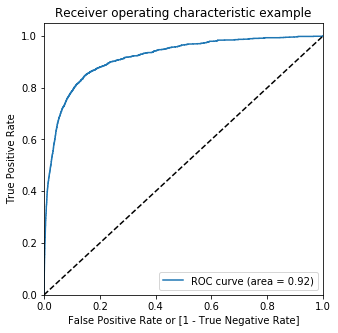

In [137]:
# Roc curve which is desirable and occupying maximum area possible
draw_roc(df_train['Churn'], df_train['prob'])

In [138]:
#predicting the target values by using different cut offs
numbers=[float(x)/10 for x in range(10)]
for i in numbers:
    df_train[i]=df_train.prob.map(lambda x: 1 if x> i else 0)
df_train.head()

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,...,0.4,0.5,0.6,0.7,0.8,0.9,prob_pred,xg_prob,xg_prob_pred,XG_prob
49099,0.0,0.0,0.0,0.0,-0.092448,0.115523,-0.189854,-0.651970,-0.566411,-0.661957,...,0,0,0,0,0,0,0,0.070440,0,0.070440
43916,0.0,0.0,0.0,0.0,-0.376268,-0.064777,-1.027289,-0.687120,-0.665967,-0.677149,...,0,0,0,0,0,0,0,0.094468,0,0.094468
87157,0.0,0.0,0.0,0.0,0.286789,-0.326941,0.316463,-0.445329,-0.447693,-0.471585,...,0,0,0,0,0,0,0,0.099353,0,0.099353
19640,0.0,0.0,0.0,0.0,2.233138,0.859130,-1.101875,0.112914,-0.482091,0.042097,...,1,1,1,1,1,1,1,0.879300,1,0.879300
21306,0.0,0.0,0.0,0.0,1.630246,1.460190,1.909555,0.490775,0.057618,0.478606,...,0,0,0,0,0,0,0,0.070440,0,0.070440


In [139]:
#For different cut offs calculating the metrics
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(df_train['Churn'], df_train[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.079751  1.000000  0.000000
0.1   0.1  0.436816  0.980037  0.389739
0.2   0.2  0.627065  0.942608  0.599719
0.3   0.3  0.734080  0.912040  0.718657
0.4   0.4  0.812040  0.876482  0.806455
0.5   0.5  0.862985  0.831566  0.865708
0.6   0.6  0.895423  0.778540  0.905552
0.7   0.7  0.918756  0.711167  0.936746
0.8   0.8  0.931990  0.615097  0.959453
0.9   0.9  0.939005  0.477230  0.979024


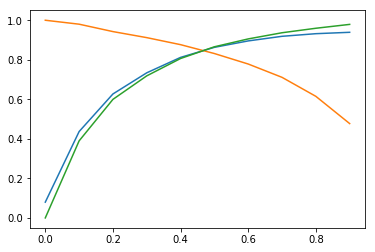

In [140]:
#Plotting the metrics accuracy,sensitivity,specificity as the intersection is at 0.5 we take cutoff as 0.5
plt.plot(cutoff_df['accuracy'])
plt.plot(cutoff_df['sensi'])
plt.plot(cutoff_df['speci'])
plt.show()

In [141]:
# Cutoff is chosen giving importance to sensitivity
df_train['lr_prob_pred']=df_train.prob.map(lambda x: 1 if x> 0.43 else 0)

In [142]:
#Accuracy for the train set
metrics.accuracy_score(df_train['Churn'],df_train['lr_prob_pred'])

0.8296019900497512

In [143]:
#Metrics of test set
cm1 = metrics.confusion_matrix(df_train['Churn'], df_train['lr_prob_pred'] )
total1=sum(sum(cm1))
accuracy = (cm1[0,0]+cm1[1,1])/total1
speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print(accuracy,speci,sensi)

0.8296019900497512 0.826512407417419 0.8652526512788522


In [144]:
df_test['prob']=list(lr_nw.predict_proba(df_test[tar_cols])[:,1])

In [145]:
df_test['lr_prob_pred']=df_test.prob.map(lambda x: 1 if x> 0.43 else 0)

In [146]:
cm1 = metrics.confusion_matrix(df_test['Churn'], df_test['lr_prob_pred'] )
total1=sum(sum(cm1))
accuracy = (cm1[0,0]+cm1[1,1])/total1
speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print(accuracy,speci,sensi)

0.8192929292929293 0.8166831519947247 0.8489388264669163


#### Considering VIF factor for the top 20columns generated

In [152]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#looking at VIF of model 
vif=pd.DataFrame()
vif['Features']=df_train[tar_cols].columns
vif['VIF']=[variance_inflation_factor(df_train[tar_cols].values,i) for i in range(df_train[tar_cols].shape[1])]
vif['VIF']=round(vif['VIF'],2)
tar_cols=[i for i in tar_cols if i not in['count_rech_2g_8','isd_og_mou_8','isd_og_mou_7','isd_og_mou_6','onnet_mou_8']]
vif


,Features,VIF
0,onnet_mou_7,2.26
1,roam_og_mou_8,2.42
2,std_og_t2f_mou_8,3.73
3,std_og_mou_8,4.26
4,total_og_mou_8,4.08
5,loc_ic_t2t_mou_6,2.60
6,loc_ic_t2t_mou_8,3.12
7,loc_ic_t2m_mou_8,2.13
8,std_ic_t2f_mou_7,3.33
9,std_ic_mou_8,2.34


#### Training the model again with 15 columns

In [153]:
#Training the model with LR using rfe features
#using sklearn model for building the logistic regression model
lr_nw=LogisticRegression(class_weight='balanced')
lr_nw.fit(df_train[tar_cols],df_train['Churn'])

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [154]:
df_train['prob']=list(lr_nw.predict_proba(df_train[tar_cols])[:,1])

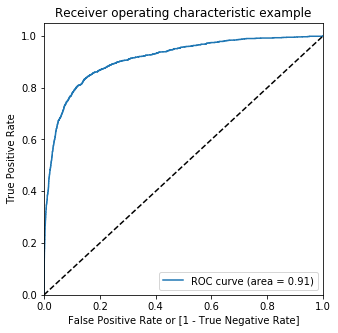

In [155]:
# Roc curve which is desirable and occupying maximum area possible
draw_roc(df_train['Churn'], df_train['prob'])

In [156]:
#predicting the target values by using different cut offs
numbers=[float(x)/10 for x in range(10)]
for i in numbers:
    df_train[i]=df_train.prob.map(lambda x: 1 if x> i else 0)
df_train.head()

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,...,0.5,0.6,0.7,0.8,0.9,prob_pred,xg_prob,xg_prob_pred,XG_prob,lr_prob_pred
49099,0.0,0.0,0.0,0.0,-0.092448,0.115523,-0.189854,-0.651970,-0.566411,-0.661957,...,0,0,0,0,0,0,0.070440,0,0.070440,0
43916,0.0,0.0,0.0,0.0,-0.376268,-0.064777,-1.027289,-0.687120,-0.665967,-0.677149,...,0,0,0,0,0,0,0.094468,0,0.094468,0
87157,0.0,0.0,0.0,0.0,0.286789,-0.326941,0.316463,-0.445329,-0.447693,-0.471585,...,0,0,0,0,0,0,0.099353,0,0.099353,0
19640,0.0,0.0,0.0,0.0,2.233138,0.859130,-1.101875,0.112914,-0.482091,0.042097,...,1,1,1,1,1,1,0.879300,1,0.879300,1
21306,0.0,0.0,0.0,0.0,1.630246,1.460190,1.909555,0.490775,0.057618,0.478606,...,0,0,0,0,0,0,0.070440,0,0.070440,0


In [157]:
#For different cut offs calculating the metrics
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(df_train['Churn'], df_train[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.079751  1.000000  0.000000
0.1   0.1  0.418159  0.978790  0.369573
0.2   0.2  0.609104  0.938241  0.580581
0.3   0.3  0.724677  0.906425  0.708926
0.4   0.4  0.803881  0.868372  0.798292
0.5   0.5  0.858010  0.822832  0.861059
0.6   0.6  0.893682  0.768559  0.904525
0.7   0.7  0.917363  0.700561  0.936152
0.8   0.8  0.932736  0.603868  0.961237
0.9   0.9  0.939453  0.458515  0.981132


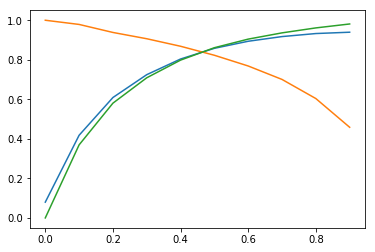

In [158]:
#Plotting the metrics accuracy,sensitivity,specificity as the intersection is at 0.5 we take cutoff as 0.5
plt.plot(cutoff_df['accuracy'])
plt.plot(cutoff_df['sensi'])
plt.plot(cutoff_df['speci'])
plt.show()

In [159]:
# Cutoff is chosen giving importance to sensitivity
df_train['lr_prob_pred']=df_train.prob.map(lambda x: 1 if x> 0.43 else 0)

In [160]:
#Accuracy for the train set
metrics.accuracy_score(df_train['Churn'],df_train['lr_prob_pred'])

0.8232338308457712

In [161]:
cm1 = metrics.confusion_matrix(df_train['Churn'], df_train['lr_prob_pred'] )
total1=sum(sum(cm1))
accuracy = (cm1[0,0]+cm1[1,1])/total1
speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print(accuracy,speci,sensi)

0.8232338308457712 0.8200789317186571 0.859638178415471


In [162]:
df_test['prob']=list(lr_nw.predict_proba(df_test[tar_cols])[:,1])

In [163]:
df_test['lr_prob_pred']=df_test.prob.map(lambda x: 1 if x> 0.43 else 0)

In [164]:
#Metrics of test set
cm1 = metrics.confusion_matrix(df_test['Churn'], df_test['lr_prob_pred'] )
total1=sum(sum(cm1))
accuracy = (cm1[0,0]+cm1[1,1])/total1
speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print(accuracy,speci,sensi)

0.8127272727272727 0.8107484338938344 0.8352059925093633


In [188]:
coff=lr_nw.coef_
df_coef=pd.DataFrame()
df_coef['features']=list(tar_cols)
df_coef['coeff']=abs(coff.T)

In [197]:
#Feature importance
df_coef.sort_values(by='coeff',ascending=False)

,features,coeff
1,roam_og_mou_8,3.033984
2,std_og_t2f_mou_8,1.757984
8,std_ic_t2f_mou_7,1.478749
11,isd_ic_mou_8,1.461472
6,loc_ic_t2t_mou_8,1.271515
13,av_rech_amt_data_8,1.160137
5,loc_ic_t2t_mou_6,0.946326
4,total_og_mou_8,0.868758
7,loc_ic_t2m_mou_8,0.818742
12,last_day_rch_amt_8,0.812945


### Recommendations

#### Below recommendation are by considering market scenarios in 2014
#### Providing better roaming packs or offers to the customers as top most important feature is roam_og_mou_8
#### Great offers for std calls both incoming and outgoing
#### Tie up with other mobile brands in proving sim netywork with attractive offers
#### Having good business deals with other operators in order to reduce tarrifs when other networks are used (IC/OG tarrifs)
#### Other important features related to t2f we can work with line provider companies for better offers and services on t2f
#### Including offers data such as carry forward the lefover data from one month to the next month can decrese churn